# Import Functions

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from pathlib import Path
import numpy as np
#import hyperspy.api as hs
import matplotlib.pyplot as plt
import numpy as np
#from dask_ml.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
import pickle
import torch.autograd as autograd
import matplotlib.gridspec as gridspec
import os
#import h5py
# from torchsummary import summary
# import pytorch_model_summary as pms
from tqdm import tqdm
#import torch.tensor as tensor
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import skimage
from skimage.feature import peak_local_max
from skimage import data, img_as_float,feature
from skimage import io
import cv2

In [2]:
torch.__version__

'1.11.0+cu102'

In [3]:
# show the version of the package, just have a look and don't need to run this line.
# import session_info
# session_info.show()

# Loading Data

In [4]:
img = np.load('02_scan_x256_y256_raw.npy')

In [5]:
img = np.transpose(img,(2,3,0,1))

In [6]:
data_r = np.copy(img)
data_r[data_r>1e3]=1e3
min_ = np.min(data_r)
max_ = np.max(data_r)

#mn = np.mean(data_r.reshape(-1))
#sd = np.std(data_r.reshape(-1))
data_r = 1.0*(data_r-min_)/(max_-min_)

In [7]:
data_r = data_r.reshape(-1,1,124,124)

In [8]:
data_r_cut = data_r[:,:,2:122,2:122]

# Set Mask

In [9]:
# set inside boundary
image_1 = np.copy(data_r_cut[100].squeeze())
window_name = 'Image'
center_coordinates = (60, 60)
radius = 12
thickness = -1
color = 100
image_2 = cv2.circle(image_1, center_coordinates, radius,color, thickness)
image_2 = np.array(image_2)
mask = (image_2==100)
mask = np.array(mask)

In [10]:
# Set Outside Boundary
image_3 = np.copy(data_r_cut[100].squeeze())
window_name = 'Image'
center_coordinates = (60, 60)
radius = 50
thickness = -1
color = 100
image_4 = cv2.circle(image_3, center_coordinates, radius,color, thickness)
image_4 = np.array(image_4)
mask_1 = (image_4==100)
mask_1 = np.array(mask_1)

In [11]:
new_mask = mask_1*~mask

In [12]:
new_mask = torch.tensor(new_mask)

# Autoencoder

In [13]:
class conv_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(conv_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_2 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_3 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_3 = nn.LayerNorm(n_step)
        self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()
        self.relu_3 = nn.ReLU()
#         self.relu_1 = nn.Tanh()
#         self.relu_2 = nn.Tanh()
#         self.relu_3 = nn.Tanh()
        #self.drop = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.relu_1(out)
        out = self.cov1d_2(out)
        out = self.relu_2(out)
        out = self.cov1d_3(out)
        out = self.norm_3(out)
        out = self.relu_3(out)
        #out = self.drop(out)
        out = out.add(x_input)
        
        return out

In [14]:
class identity_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(identity_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_1 = nn.LayerNorm(n_step)
        #self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
#        self.relu = nn.Tanh()
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.norm_1(out)
        out = self.relu(out)
        #output = self.drop(x)
        
        return out

In [15]:
class Encoder(nn.Module):
    def __init__(self,original_step_size,pool_list,embedding_size,conv_size,num_basis=2):
        super(Encoder,self).__init__()
        
        blocks = []
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        number_of_blocks = len(pool_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(nn.MaxPool2d(pool_list[0], stride=pool_list[0]))
        for i in range(1,number_of_blocks):
            original_step_size = [original_step_size[0]//pool_list[i-1],original_step_size[1]//pool_list[i-1]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(nn.MaxPool2d(pool_list[i], stride=pool_list[i])) 
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        original_step_size = [original_step_size[0]//pool_list[-1],original_step_size[1]//pool_list[-1]]
        
        input_size = original_step_size[0]*original_step_size[1]
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()
        self.tanh = nn.Tanh()
 
        self.before = nn.Linear(input_size,20)
        self.dense = nn.Linear(20+num_basis,embedding_size)
        
        
        self.for_k = nn.Linear(20,num_basis)
        self.norm = nn.LayerNorm(num_basis)
        self.softmax = nn.Softmax()
        self.num_k_sparse=1
        
    def ktop(self,x):
        kout = self.for_k(x)
        kout = self.norm(kout)
        kout = self.softmax(kout)
        k_no = kout.clone()

        k = self.num_k_sparse
        with torch.no_grad():
            if k <= kout.shape[1]:
                for raw in k_no:
                    indices = torch.topk(raw, k)[1].to(device)
                    mask = torch.ones(raw.shape, dtype=bool).to(device)
                    mask[indices] = False
                    raw[mask] = 0
                    raw[~mask] = 1
        return k_no
    
    

    def find_type(self):
       
        return self.emoji
    
    def forward(self,x):

        out = x.view(-1,1,self.input_size_0,self.input_size_1)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        out = torch.flatten(out,start_dim=1)
        kout = self.before(out) 
        
        k_out = self.ktop(kout)
        out = torch.cat((kout,k_out),dim=1).to(device)
        out = self.dense(out)
        scale_1 = 0.2*nn.Tanh()(out[:,0])+1
        scale_2 = 0.2*nn.Tanh()(out[:,1])+1
#        trans_1 = out[:,0]
#        trans_2 = out[:,1]
        rotate = out[:,2]
        a_1 = torch.cos(rotate)
#        a_2 = -torch.sin(selection)
        a_2 = torch.sin(rotate)    
#        a_4 = torch.ones(rotate.shape).to(device)
        a_5 = rotate*0
        b1 = torch.stack((a_1,a_2), dim=1).squeeze()
        b2 = torch.stack((-a_2,a_1), dim=1).squeeze()
        b3 = torch.stack((a_5,a_5), dim=1).squeeze()
        rotation = torch.stack((b1, b2, b3), dim=2)        
        c1 = torch.stack((scale_1,a_5), dim=1).squeeze()
        c2 = torch.stack((a_5,scale_2), dim=1).squeeze()
        c3 = torch.stack((a_5,a_5), dim=1).squeeze()
        scaler = torch.stack((c1, c2, c3), dim=2)        
#         d1 = torch.stack((a_4,a_5), dim=1).squeeze()
#         d2 = torch.stack((a_5,a_4), dim=1).squeeze()
#         d3 = torch.stack((trans_1,trans_2), dim=1).squeeze()
#         translation = torch.stack((d1, d2, d3), dim=2)
        
        grid_1 = F.affine_grid(rotation.to(device), x.size()).to(device)
        out_r = F.grid_sample(x, grid_1)
        
        grid_2 = F.affine_grid(scaler.to(device), x.size()).to(device)
        output = F.grid_sample(out_r, grid_2)
        
#         grid_3 = F.affine_grid(translation.to(device), x.size()).to(device)
#         output = F.grid_sample(out_r, grid_3)
   
        
        return output,k_out,rotation,scaler

In [16]:
class Decoder(nn.Module):
    def __init__(self,original_step_size,up_list,embedding_size,conv_size,num_basis=2):
        super(Decoder,self).__init__()
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        self.dense = nn.Linear(num_basis,original_step_size[0]*original_step_size[1])
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        
        blocks = []
        number_of_blocks = len(up_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        for i in range(number_of_blocks):
            blocks.append(nn.Upsample(scale_factor=up_list[i], mode='bilinear', align_corners=True))
            original_step_size = [original_step_size[0]*up_list[i],original_step_size[1]*up_list[i]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        
        self.output_size_0 = original_step_size[0]
        self.output_size_1 = original_step_size[1]
        
#        input_size = original_step_size[0]*original_step_size[1]
        self.relu_1 = nn.ReLU()
 

        
    def forward(self,x):
 #       print(x.shape)

        out = self.dense(x)
        out = out.view(-1,1,self.input_size_0,self.input_size_1)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        out = self.relu_1(out)
        
#        out = out.view()
#        out = self.softmax(out)
        
        return out

In [17]:
class Joint(nn.Module):
    def __init__(self,encoder,decoder):
        super(Joint,self).__init__()
        
        self.encoder  = encoder
        self.decoder = decoder

        
    def forward(self,x):
 #       print(x.shape)
        predicted,k_out,rotation,scaler = self.encoder(x)
    
        identity = torch.tensor([0,0,1],dtype= torch.float).reshape(1,1,3).repeat(x.shape[0],1,1).to(device)
        
        new_theta_1 = torch.cat((rotation,identity),axis=1).to(device)
        new_theta_2 = torch.cat((scaler,identity),axis=1).to(device)
#        new_theta_3 = torch.cat((translation,identity),axis=1).to(device)
        
        inver_theta_1 = torch.linalg.inv(new_theta_1)[:,0:2].to(device) 
        inver_theta_2 = torch.linalg.inv(new_theta_2)[:,0:2].to(device)
#        inver_theta_3 = torch.linalg.inv(new_theta_3)[:,0:2].to(device) 
        
        grid_1 = F.affine_grid(inver_theta_1.to(device), x.size()).to(device)
        grid_2 = F.affine_grid(inver_theta_2.to(device), x.size()).to(device)
#        grid_3 = F.affine_grid(inver_theta_3.to(device), x.size()).to(device)
        
        predicted_base = self.decoder(k_out)
        
#        predicted_t = F.grid_sample(predicted_base, grid_3)
        predicted_s = F.grid_sample(predicted_base, grid_2)
        predicted_input = F.grid_sample(predicted_s, grid_1)
        
        
        return predicted,predicted_base,predicted_input,k_out,rotation,scaler

In [20]:
device = torch.device('cuda:0')

# Setting Parameters

In [21]:
en_original_step_size=[120,120]
pool_list=[4,3,2]

de_original_step_size = [5,5]
up_list = [2,3,4]
embedding_size=3
conv_size =128
num_basis=2

In [22]:
encoder = Encoder(original_step_size=en_original_step_size,
                  pool_list=pool_list,
                  embedding_size=embedding_size,
                  conv_size=conv_size,
                  num_basis=num_basis).to(device)
decoder = Decoder(original_step_size=de_original_step_size,
                  up_list=up_list,
                  embedding_size=embedding_size,
                  conv_size=conv_size,
                  num_basis=num_basis).to(device)
join = Joint(encoder,decoder).to(device)

In [23]:
optimizer = optim.Adam(join.parameters(), lr=3e-5)

# Load weights

In [24]:
path_checkpoint = "4.20_base=2_Add_Scale_regul_lr_0.00006_epoch_5565_trainloss_0.0141_l2_0.00030_sr_0.00048.pkl"
checkpoint = torch.load(path_checkpoint, )#map_location=torch.device('cpu'))  

join.load_state_dict(checkpoint['net'])
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
optimizer.load_state_dict(checkpoint['optimizer']) 
start_epoch = checkpoint['epoch']
start_coef = checkpoint['coef_entropy']

# Generate Results

In [25]:
train_iterator = torch.utils.data.DataLoader(data_r_cut, batch_size = 30,shuffle = True)

In [26]:
sample = next(iter(train_iterator))

In [27]:
predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2 = join(sample.to(device, dtype=torch.float))

/tmp/ipykernel_2539/573285901.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  kout = self.softmax(kout)
/opt/conda/envs/4d_tem/lib/python3.8/site-packages/torch/nn/functional.py:4255: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/conda/envs/4d_tem/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor([0., 1.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[ 0.8038, -0.5949,  0.0000],
        [ 0.5949,  0.8038,  0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[1.1562, 0.0000, 0.0000],
        [0.0000, 1.1266, 0.0000]], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 1.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[ 0.8891, -0.4578,  0.0000],
        [ 0.4578,  0.8891,  0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[1.1560, 0.0000, 0.0000],
        [0.0000, 1.1274, 0.0000]], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 1.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[ 0.9997,  0.0247, -0.0000],
        [-0.0247,  0.9997, -0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[1.1598, -0.0000, -0.0000],
        [-0.0000, 1.1151, -0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0., 1.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[ 0.9551, -0.2961,  

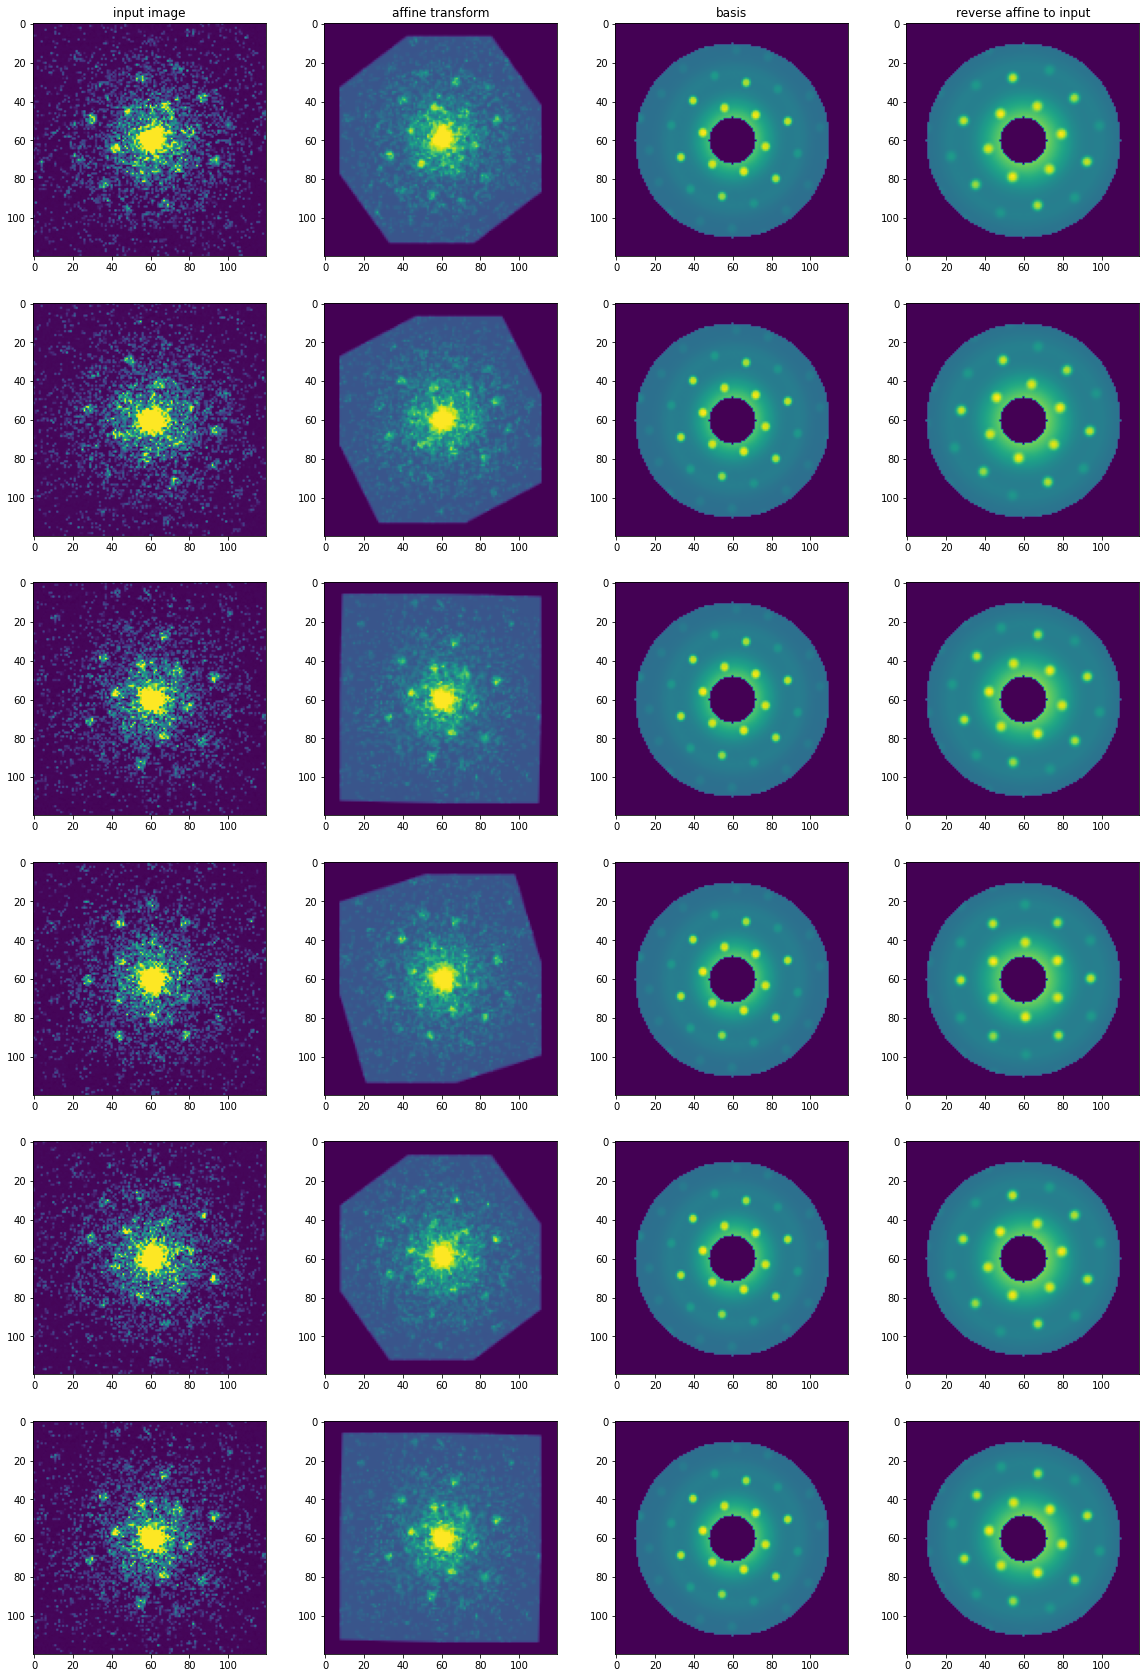

In [28]:
# Visualize the result
fig,ax = plt.subplots(6,4,figsize=(20,30))
for i in range(6):
    j = np.random.randint(0,30)
    #i = 247
    if i==0:
        ax[i][0].title.set_text('input image')
        ax[i][1].title.set_text('affine transform')
        ax[i][2].title.set_text('basis')
        ax[i][3].title.set_text('reverse affine to input')
    ax[i][0].imshow(sample[j].squeeze())
    
    ax[i][1].imshow(predicted_x[j].squeeze().detach().cpu())
    
    #ax[2].imshow((card_small.squeeze()-out[i].squeeze().detach().cpu())**2)
    #num = torch.argmax(prob[i])
    recreate_base = predicted_base[j].squeeze().detach().cpu()
    recreate_base[~new_mask]=0
    ax[i][2].imshow(recreate_base)
    
    rever_base = predicted_input[j].squeeze().detach().cpu()
    rever_base[~new_mask]=0
    ax[i][3].imshow(rever_base)
    
    #ax[3].imshow((label_[num].squeeze()-out[i].squeeze().detach().cpu())**2)
    print(kout[j])
#    print(theta_1[j])
    print(theta_1[j])
#    print(y[0][j],y[1][j])
#    print(theta[j]
    print(theta_2[j])
#plt.savefig('figures/Sampledata_4d_Wse2WS_base=2.png',format = 'png')

In [29]:
train_iterator = torch.utils.data.DataLoader(data_r_cut, batch_size = 64,shuffle = False)

In [30]:
base_8 = np.zeros([65536,2])
rotation_ = np.zeros([65536,2])
scale_ = np.zeros([65536,4])
total_loss = 0
#y0=np.zeros([11767])
#y1 = np.zeros([11767])
for i, x in enumerate(train_iterator):
    with torch.no_grad():
        value = x
        test_value = Variable(value)
        test_value = test_value.float()
        #    result,a,b,c = model(test_value)
        predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2= join(test_value.to(device, dtype=torch.float))
        
        loss = F.mse_loss(predicted_base.to('cpu').squeeze(), predicted_x.to('cpu').squeeze(), reduction='mean')\
        + F.mse_loss(predicted_input.to('cpu').squeeze(), x.to('cpu').squeeze(), reduction='mean')
        
        total_loss+=loss
        
        
        base_8[i*64:(i+1)*64] = kout.cpu().detach().numpy()
        
        rotation_[i*64:(i+1)*64] = theta_1[:,:,0].cpu().detach().numpy()
        
        scale_[i*64:(i+1)*64] = theta_2[:,:,0:2].cpu().detach().numpy().reshape(-1,4)
        #    mn,st,log,embedding = encoder(test_value)
        #     result1 = result1.reshape(784,1000,1)
#        learned[i*41:(i+1)*41,:] = theta_
#        y0[i*41:(i+1)*41] = y[0].numpy()
#        y1[i*41:(i+1)*41] = y[1].numpy()
        if i%10==0:
            print('the predict process is ...'+ format(100*i/len(train_iterator),'.2f')+ '%')
total_loss/=256
print('mse_loss'+str(total_loss))

/tmp/ipykernel_2539/573285901.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  kout = self.softmax(kout)


the predict process is ...0.00%
the predict process is ...0.98%
the predict process is ...1.95%
the predict process is ...2.93%
the predict process is ...3.91%
the predict process is ...4.88%
the predict process is ...5.86%
the predict process is ...6.84%
the predict process is ...7.81%
the predict process is ...8.79%
the predict process is ...9.77%
the predict process is ...10.74%
the predict process is ...11.72%
the predict process is ...12.70%
the predict process is ...13.67%
the predict process is ...14.65%
the predict process is ...15.62%
the predict process is ...16.60%
the predict process is ...17.58%
the predict process is ...18.55%
the predict process is ...19.53%
the predict process is ...20.51%
the predict process is ...21.48%
the predict process is ...22.46%
the predict process is ...23.44%
the predict process is ...24.41%
the predict process is ...25.39%
the predict process is ...26.37%
the predict process is ...27.34%
the predict process is ...28.32%
the predict process i

0
1
total activated channels: 2


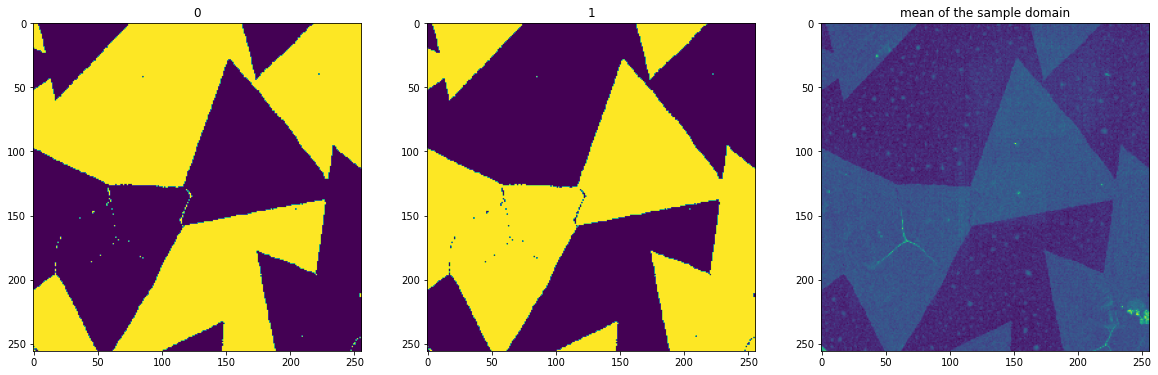

In [31]:
#base=2,loss=0.024
j=0
list_new = []
fig,ax = plt.subplots(1,3,figsize=(20,10))
for i in range(2):
#     m = int(i/3)
#     n = i%2
    if np.sum(base_8[:,i]!=0):
        j+=1
        print(i)
        list_new.append(i)
        ax[i].title.set_text(str(i))
        ax[i].imshow(base_8[:,i].reshape(256,256))
print('total activated channels: '+str(j))
ax[2].title.set_text('mean of the sample domain')
ax[2].imshow(np.mean(data_r_cut.reshape(256,256,-1),axis=2))

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 9.0000e+00, 1.0800e+02, 1.6100e+02, 1.3600e+02,
        4.1400e+02, 1.2260e+03, 1.2210e+03, 3.3400e+02, 2.7000e+01,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 4.0000e+00,
        1.8000e+01, 3.6000e+01, 1.6200e+02, 2.2400e+02, 1.4500e+02,
        2.0000e+02, 8.1800e+02, 1.0360e+03, 1.1560e+03, 1.0940e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        3.5500e+02, 2.0100e+02, 3.0000e+00, 0.0000e+00, 8.0000e+00,
        2.1000e+01, 1.5900e+02, 5.4900e+02, 6.7400e+02, 5.2100e+02,
        1.9000e+02, 3.0000e+01, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 4.0000e+00, 3.0000e+00, 2.0000e+00, 3.0000e+00,
        6.0000e+00, 2.0000e+01, 1.6000e+01, 1.40

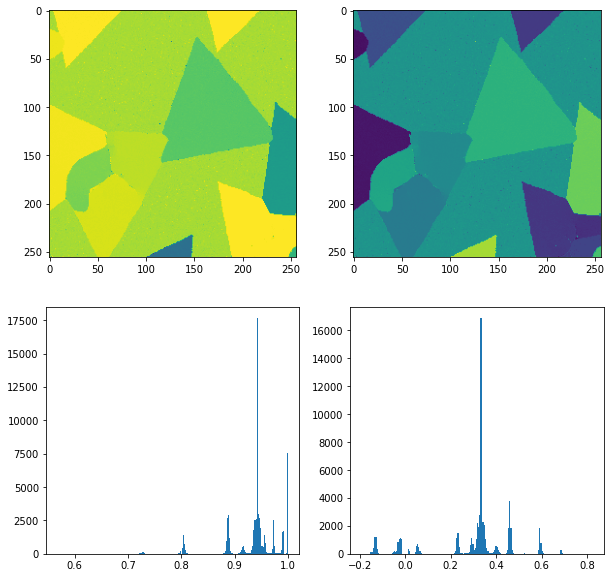

In [32]:
fig,ax = plt.subplots(2,2,figsize = (10,10))
ax[0][0].imshow(rotation_[:,0].reshape(256,256))
ax[0][1].imshow(rotation_[:,1].reshape(256,256))
ax[1][0].hist(rotation_[:,0].reshape(-1),200)
ax[1][1].hist(rotation_[:,1].reshape(-1),200)

In [33]:
sample_base = base_8[:,1].reshape(256,256)

In [34]:
scale_0 = np.multiply(sample_base.reshape(256,256),scale_[:,0].reshape(256,256))
scale_1 = np.multiply(sample_base.reshape(256,256),scale_[:,3].reshape(256,256))

(array([  0.,   1.,   2.,   2.,   3.,   4.,   7.,   5.,   5.,   5.,   7.,
          7.,  11.,   6.,  19.,   7.,  16.,  22.,  15.,  19.,  31.,  42.,
         43.,  29.,  39.,  42.,  48.,  61., 102.,  91., 111., 144., 124.,
        133., 139., 156., 158., 182., 225., 202., 289., 298., 325., 350.,
        413., 390., 421., 456., 455., 482., 514., 546., 550., 553., 567.,
        568., 552., 667., 597., 605., 598., 630., 630., 562., 571., 594.,
        592., 538., 614., 605., 581., 558., 546., 488., 492., 484., 410.,
        378., 374., 338., 359., 303., 343., 291., 260., 275., 264., 245.,
        271., 249., 248., 197., 190., 179., 172., 206., 174., 161., 179.,
        146., 146., 143., 120., 149., 137., 113., 121., 114., 134., 107.,
         87., 105.,  97.,  89.,  85.,  94.,  83.,  84.,  84.,  89.,  95.,
         85.,  83.,  79.,  75.,  77.,  79.,  75.,  65.,  54.,  55.,  42.,
         42.,  36.,  34.,  39.,  44.,  34.,  37.,  36.,  36.,  31.,  38.,
         37.,  20.,  31.,  33.,  25., 

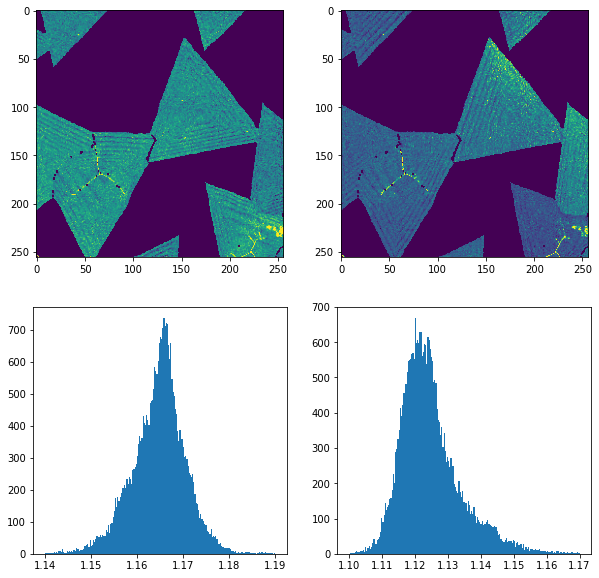

In [35]:
fig,ax = plt.subplots(2,2,figsize = (10,10))
clim0 = [1.14,1.19]
clim1 = [1.1,1.17]
ax[0][0].imshow(scale_0,clim=clim0)
ax[0][1].imshow(scale_1,clim=clim1)
ax[1][0].hist(scale_0.reshape(-1),200,range=clim0)
ax[1][1].hist(scale_1.reshape(-1),200,range=clim1)
#fig.savefig('scale_parameter.png')

In [36]:
right_tri = np.sqrt(scale_0**2+scale_1**2).reshape(256,256)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          1.,   0.,   0.,   1.,   2.,   0.,   3.,   3.,   0.,   1.,   3.,
          3.,   3.,   6.,   5.,   2.,  10.,   2.,   5.,   8.,   8.,  10.,
          9.,  11.,  20.,  21.,  10.,  20.,  29.,  17.,  22.,  44.,  31.,
         34.,  42.,  42.,  54.,  54.,  63.,  84.,  58.,  75.,  93., 102.,
        112., 102., 103., 141., 145., 145., 149., 178., 187., 216., 199.,
        213., 239., 281., 257., 286., 310., 281., 319., 329., 381., 414.,
        400., 417., 433., 457., 456., 485., 455., 514., 478., 584., 539.,
        523., 600., 534., 572., 607., 627., 579., 543., 544., 592., 540.,
        532., 537., 568., 492., 503., 497., 478., 449., 448., 442., 403.,
        387., 363., 374., 367., 336., 324., 313., 318., 295., 295., 235.,
        231., 234., 232., 214., 208., 192., 179., 169., 161., 155., 138.,
        165., 143., 114., 118., 121., 108., 122.,  94.,  94.,  92.,  72.,
         73.,  65.,  68.,  71.,  51., 

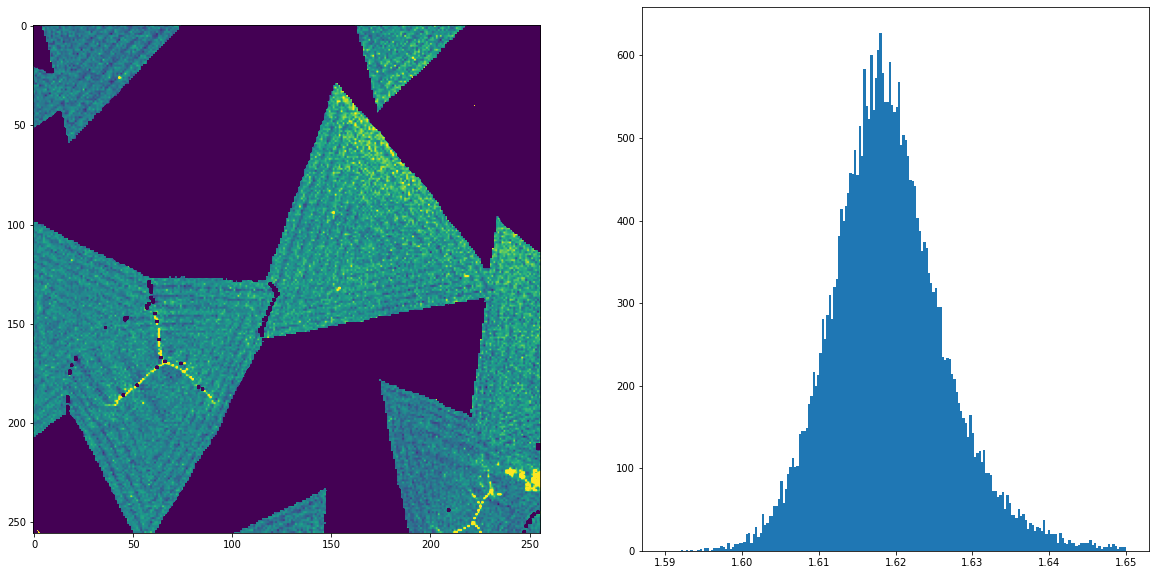

In [37]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
clim=[1.59,1.65]
ax[0].imshow(right_tri,clim=clim)
ax[1].hist(right_tri.reshape(-1),200,range=clim)

In [32]:
x = torch.randn(1, 48, 48, 1, requires_grad=True)
torch.onnx.export(encoder, x, "new_model_torchToOnnx.onnx", verbose=True, input_names = ['input'], output_names = ['output'])

RuntimeError: shape '[-1, 1, 120, 120]' is invalid for input of size 2304

In [ ]:
import onnxruntime as rt
import numpy

sess = rt.InferenceSession("new_model_torchToOnnx.onnx")
input_name = sess.get_inputs()[0].name

# Note: The input must be of the same shape as the shape of x during # the model export part. i.e. second argument in this function call: torch.onnx.export()
onnxPredictions = sess.run(None, {input_name: sample.numpy().reshape(30,120,120,1)})[0]

In [30]:
sample.shape

torch.Size([30, 1, 120, 120])

In [36]:
encoder

Encoder(
  (block_layer): ModuleList(
    (0): conv_block(
      (cov1d_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cov1d_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cov1d_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm_3): LayerNorm((120, 120), eps=1e-05, elementwise_affine=True)
      (relu_1): ReLU()
      (relu_2): ReLU()
      (relu_3): ReLU()
    )
    (1): identity_block(
      (cov1d_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm_1): LayerNorm((120, 120), eps=1e-05, elementwise_affine=True)
      (relu): ReLU()
    )
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): conv_block(
      (cov1d_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cov1d_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cov1d_3): Conv2d(128, 128, kernel_size=(3, 3